In [14]:
import pandas as pd
from sklearn.impute import SimpleImputer

X_test = pd.read_csv("./X_test.csv")
df_y_test = pd.read_csv("./y_test.csv")
y_test = df_y_test.squeeze().astype(int) - 1  # Shift to 0-indexed classes
X_train = pd.read_csv("./X_train.csv")
df_y_train = pd.read_csv("./y_train.csv")
y_train = df_y_train.squeeze().astype(int) - 1  # Shift to 0-indexed classes

# One-hot encode categorical columns
categorical_cols = ['outlook', 'prioroutlook']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure both train and test have the same columns (handle unseen categories)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Handle missing values with median imputation
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"y_train classes: {sorted(y_train.unique())}")

X_train shape: (1664, 71)
X_test shape: (290, 71)
Missing values in X_train: 0
Missing values in X_test: 0
y_train classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


In [15]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# ----- Convert labels to 1D integers -----
le = LabelEncoder()
y_train_np = le.fit_transform(y_train.values.ravel())  # <- important: ravel() to 1D
y_test_np = le.transform(y_test.values.ravel())

# ----- Convert features to float32 -----
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

# ----- Compute sample weights to handle class imbalance -----
classes = np.unique(y_train_np)
class_weight_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
# Create per-sample weights based on class
sample_weights = np.array([class_weight_values[y] for y in y_train_np], dtype=np.float32)

print("Class weight values:", class_weight_values)
print("Sample weights shape:", sample_weights.shape)

# ----- TabNet classifier -----
clf = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=4,
    gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size": 20, "gamma": 0.9},
    verbose=1
)

# ----- Fit the model with sample weights -----
clf.fit(
    X_train_np,
    y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_metric=['balanced_accuracy'],
    max_epochs=200,
    patience=30,
    batch_size=64,           # much smaller for small dataset
    virtual_batch_size=32,   # helps with gradient stability
    num_workers=0,
    weights=1  # Use 1 for automated class balancing, or pass sample_weights for custom
)

# ----- Predict and evaluate -----
y_pred = clf.predict(X_test_np)

print("\n" + "="*50)
print("RESULTS")
print("="*50)
print("Accuracy:", accuracy_score(y_test_np, y_pred))
print(classification_report(y_test_np, y_pred, zero_division=0))

Class weight values: [1.12053872 1.4006734  1.12053872 0.96352056 0.84509904 0.94545455
 0.84984678 0.76400367 0.90582471 1.27119939 1.18181818]
Sample weights shape: (1664,)


/Users/hannahchoi/predicting-corporate-credit-ratings/.venv/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.25238 | val_0_balanced_accuracy: 0.10453 |  0:00:00s
epoch 1  | loss: 3.65068 | val_0_balanced_accuracy: 0.1035  |  0:00:00s
epoch 2  | loss: 3.20629 | val_0_balanced_accuracy: 0.10173 |  0:00:01s
epoch 3  | loss: 3.0395  | val_0_balanced_accuracy: 0.11472 |  0:00:01s
epoch 4  | loss: 3.01252 | val_0_balanced_accuracy: 0.1015  |  0:00:01s
epoch 5  | loss: 2.90807 | val_0_balanced_accuracy: 0.11007 |  0:00:02s
epoch 6  | loss: 2.89267 | val_0_balanced_accuracy: 0.08908 |  0:00:02s
epoch 7  | loss: 2.8517  | val_0_balanced_accuracy: 0.10928 |  0:00:02s
epoch 8  | loss: 2.85106 | val_0_balanced_accuracy: 0.10555 |  0:00:03s
epoch 9  | loss: 2.8149  | val_0_balanced_accuracy: 0.13302 |  0:00:03s
epoch 10 | loss: 2.77257 | val_0_balanced_accuracy: 0.11529 |  0:00:04s
epoch 11 | loss: 2.74987 | val_0_balanced_accuracy: 0.09979 |  0:00:04s
epoch 12 | loss: 2.69576 | val_0_balanced_accuracy: 0.0912  |  0:00:04s
epoch 13 | loss: 2.66673 | val_0_balanced_accuracy: 0.12834 |  0

/Users/hannahchoi/predicting-corporate-credit-ratings/.venv/lib/python3.13/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [19]:
print("Accuracy:", accuracy_score(y_test_np, y_pred))

Accuracy: 0.27241379310344827


In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Calculate within ±1 class accuracy
def tolerance_accuracy(y_true, y_pred, tolerance=1):
    """Calculate accuracy within a tolerance of the true class."""
    return np.mean(np.abs(y_true - y_pred) <= tolerance)

within_1_accuracy = tolerance_accuracy(y_test_np, y_pred, tolerance=1)
print(f"Within ±1 Class Accuracy: {within_1_accuracy:.4f} ({within_1_accuracy*100:.2f}%)")

# Calculate ROC AUC
y_pred_proba = clf.predict_proba(X_test_np)
classes = np.arange(11)  # 0-10 classes
y_test_bin = label_binarize(y_test_np, classes=classes)

roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
print(f"ROC AUC (macro): {roc_auc:.4f}")

Within ±1 Class Accuracy: 0.5310 (53.10%)
ROC AUC (macro): 0.8093


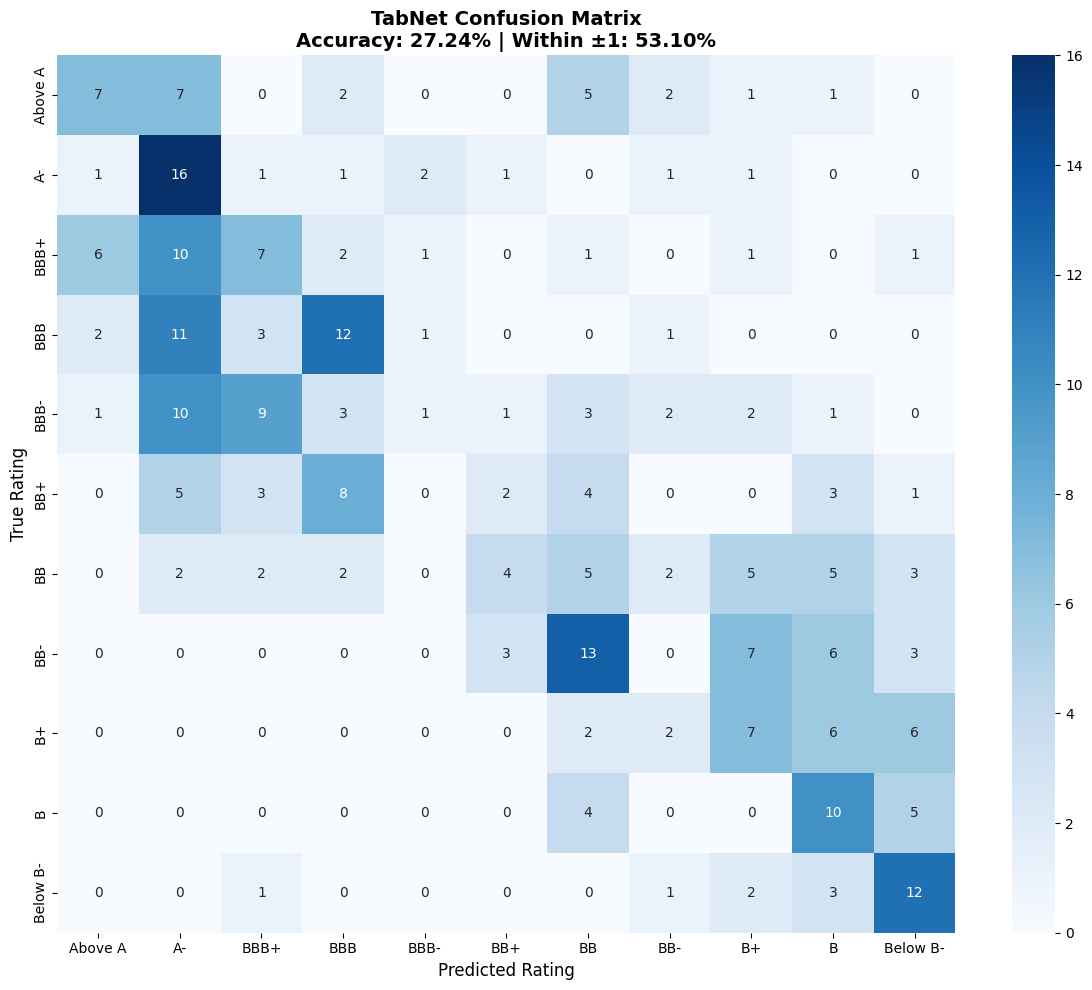


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Above A       0.41      0.28      0.33        25
          A-       0.26      0.67      0.38        24
        BBB+       0.27      0.24      0.25        29
         BBB       0.40      0.40      0.40        30
        BBB-       0.20      0.03      0.05        33
         BB+       0.18      0.08      0.11        26
          BB       0.14      0.17      0.15        30
         BB-       0.00      0.00      0.00        32
          B+       0.27      0.30      0.29        23
           B       0.29      0.53      0.37        19
    Below B-       0.39      0.63      0.48        19

    accuracy                           0.27       290
   macro avg       0.25      0.30      0.26       290
weighted avg       0.24      0.27      0.24       290



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import sys

from sklearn import svm, metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform

# Create rating labels mapping
merged_rating_order_str = ['Above A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'Below B-']
merged_rating_map_num = {rating: i+1 for i, rating in enumerate(merged_rating_order_str)}
inverted_merged_rating_map_str = {v: k for k, v in merged_rating_map_num.items()}

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)
cm_df = pd.DataFrame(cm, index=merged_rating_order_str, columns=merged_rating_order_str)

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'TabNet Confusion Matrix\nAccuracy: 27.24% | Within ±1: 53.10%', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Rating', fontsize=12)
plt.ylabel('True Rating', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print(f"\n{'='*80}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*80}")
print(classification_report(y_test, y_pred, target_names=merged_rating_order_str, zero_division=0))